# ML3: Deep Learning | Lab 2 | Danila Pechenev

In [1]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy

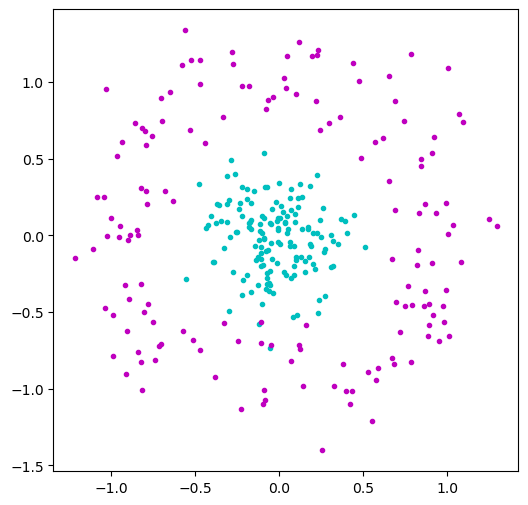

In [2]:
X, y = make_circles(n_samples=300, noise=0.2, factor=0.1)
n, d = X.shape
plt.figure(1, figsize=[6, 6])
plt.plot(X[:, 0][np.where(y == 1)], X[:, 1][np.where(y == 1)], '.c')
plt.plot(X[:, 0][np.where(y == 0)], X[:, 1][np.where(y == 0)], '.m')
plt.show()

In [3]:
def sigmoid(x):
    res = 1 / (1 + np.exp(-x))
    return res

In [4]:
class InputUnit:
    def __init__(self, data):
        self.data = data  # one column of matrix X
        self.n = data.shape[0]  # dataset size
        self.k = 0  # layer number
        self.z = 0  # unit output

    def forward(self, i):
        self.z = self.data[i]
        return self.z

In [5]:
class NeuralUnit:
    def __init__(self, k, u):
        self.k = k  # layer number
        self.u = u  # unit number
        self.preceding = []  # list of preceding neurons
        self.npr = 0  # length of list preceding
        self.w = 0  # unit weights
        self.b = 0  # unit intercept
        self.z = 0  # unit output
        
    def reset_params(self):
        self.w = np.random.randn(self.npr)
        self.b = np.random.randn()

    def plug(self, preceding_units):
        self.preceding = preceding_units
        self.npr = len(self.preceding)

    def forward(self, i):
        zin = np.array([unit.forward(i) for unit in self.preceding])
        self.z = sigmoid(np.dot(self.w, zin) + self.b)
        return self.z

    def backprop(self, i, deltas):
        self.delta = np.zeros(self.w.shape)
        self.w_grad = np.zeros(self.w.shape)
        for v in range(self.npr):
            self.delta[v] = self.z * (1 - self.z) * self.w[v] * deltas[self.u]
            self.w_grad[v] = self.z * (1 - self.z) * self.preceding[v].z * deltas[self.u]
    
        self.b_grad = self.z * (1 - self.z) * deltas[self.u]

In [6]:
class Loss:
    def __init__(self, y, k):
        self.k = k  # layer index
        self.preceding = []  # list of preceding neurons
        self.npr = 0  # length of list preceding
        self.y = y  # array of class labels of the training data
        
    def plug(self, preceding_units):
        self.preceding = preceding_units  # normally, only 1 preceding unit
        self.npr = len(self.preceding)
        assert self.npr == 1

    def forward(self, i):
        zin = self.preceding[0].forward(i)
        if self.y[i] == 0:
            return -np.log(1 - zin)
        else:
            return -np.log(zin)

    def backprop(self, i):
        zin = self.preceding[0].z
        self.delta = np.zeros((1,))
        if self.y[i] == 0:
            self.delta[0] = 1 / (1 - zin)
        else:
            self.delta[0] = -1 / zin

In [7]:
class MLP:
    def __init__(self, X, y, archi):
        self.X = X
        self.y = y
        self.archi = archi
        self.K = len(archi)  # number of layers (including input layer but omitting loss layer)
        self.n = X.shape[0]
        
        units = []
        for layer_idx in range(self.K):
            units.append([])
            for unit_idx in range(self.archi[layer_idx]):
                if layer_idx == 0:
                    unit = InputUnit(self.X[:, unit_idx])
                else:
                    unit = NeuralUnit(layer_idx, unit_idx)
                units[-1].append(unit)
        
        units.append([Loss(self.y, self.K)])

        units[-1][0].plug(units[-2])
        for layer_idx in range(1, self.K):
            for unit in units[layer_idx]:
                unit.plug(units[layer_idx - 1])
                unit.reset_params()
        
        self.net = units

    def forward(self, i):
        return self.net[-1][0].forward(i)

    def backprop(self, i):
        # loss layer
        self.net[-1][0].backprop(i)
        deltas = self.net[-1][0].delta
    
        # neural layers (backward)
        for k in range(self.K - 1, 0, -1):
            deltas_new = np.zeros((self.net[k][0].npr,))
            for u in range(len(self.net[k])):
                self.net[k][u].backprop(i, deltas)
                deltas_new += self.net[k][u].delta
    
            deltas = deltas_new

    def update(self, eta):
        for layer_idx in range(1, self.K):
            for unit_idx in range(self.archi[layer_idx]):
                unit = self.net[layer_idx][unit_idx]
                unit.w -= eta * unit.w_grad
                unit.b -= eta * unit.b_grad

    def train(self, epochs, eta):
        for epoch in range(epochs):
            for i in range(self.n):
                self.forward(i)
                self.backprop(i)
                self.update(eta)

    def predict(self, i):
        return self.net[-2][0].forward(i)

In [8]:
def test_connections():
    mlp = MLP(X, y, [2, 2, 1])
    assert mlp.net[1][0].preceding[0] == mlp.net[0][0] and mlp.net[1][0].preceding[1] == mlp.net[0][1]
    assert mlp.net[1][1].preceding[0] == mlp.net[0][0] and mlp.net[1][1].preceding[1] == mlp.net[0][1]
    assert mlp.net[2][0].preceding[0] == mlp.net[1][0] and mlp.net[2][0].preceding[1] == mlp.net[1][1]

In [9]:
test_connections()

In [10]:
mlp = MLP(X, y, [2, 2, 1])
print(f"Initial weights of the first neural unit: w = {mlp.net[1][0].w}, b = {mlp.net[1][0].b}")
print(f"Initial weights of the second neural unit: w = {mlp.net[1][1].w}, b = {mlp.net[1][1].b}")
print(f"Initial weights of the third neural unit: w = {mlp.net[2][0].w}, b = {mlp.net[2][0].b}")

Initial weights of the first neural unit: w = [-1.02531676  0.0727511 ], b = 1.3398378863674882
Initial weights of the second neural unit: w = [ 1.25055654 -1.19012393], b = 1.0823386569262055
Initial weights of the third neural unit: w = [-0.30686723  0.38250229], b = -0.17736827878999126


In [11]:
np.random.seed(0)
i = 0
archi = [2, 10, 1]
mlp = MLP(X, y, archi)
mlp.forward(i)
mlp.backprop(i)
epsi = 1e-3
mlp2 = copy.deepcopy(mlp)
mlp2.net[1][0].w[0] = mlp.net[1][0].w[0] + epsi
print("Numerical derivative is:", (mlp2.forward(i) - mlp.forward(i)) / epsi)
print("Computed derivative is: ", mlp.net[1][0].w_grad[0])

Numerical derivative is: 0.00042574406363543593
Computed derivative is:  0.0004259189854566669


In [12]:
def plot_decision_boundary(ax, mlp, X, y, h=0.02):
    x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    x11, x22 = np.meshgrid(
        np.arange(x1_min, x1_max, h),
        np.arange(x2_min, x2_max, h)
    )

    X_disp = np.c_[x11.ravel(), x22.ravel()]
    n_disp = X_disp.shape[0]

    # temporarily replace input data
    for u in range(mlp.archi[0]):
        mlp.net[0][u].data = X_disp[:, u]

    Z = [mlp.predict(i) for i in range(n_disp)]

    # restore original data
    for u in range(mlp.archi[0]):
        mlp.net[0][u].data = X[:, u]

    Z = np.array(Z).reshape(x11.shape)

    ax.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)
    ax.plot(X[:,0][y==1], X[:,1][y==1], '.r', markersize=4)
    ax.plot(X[:,0][y==0], X[:,1][y==0], '.b', markersize=4)

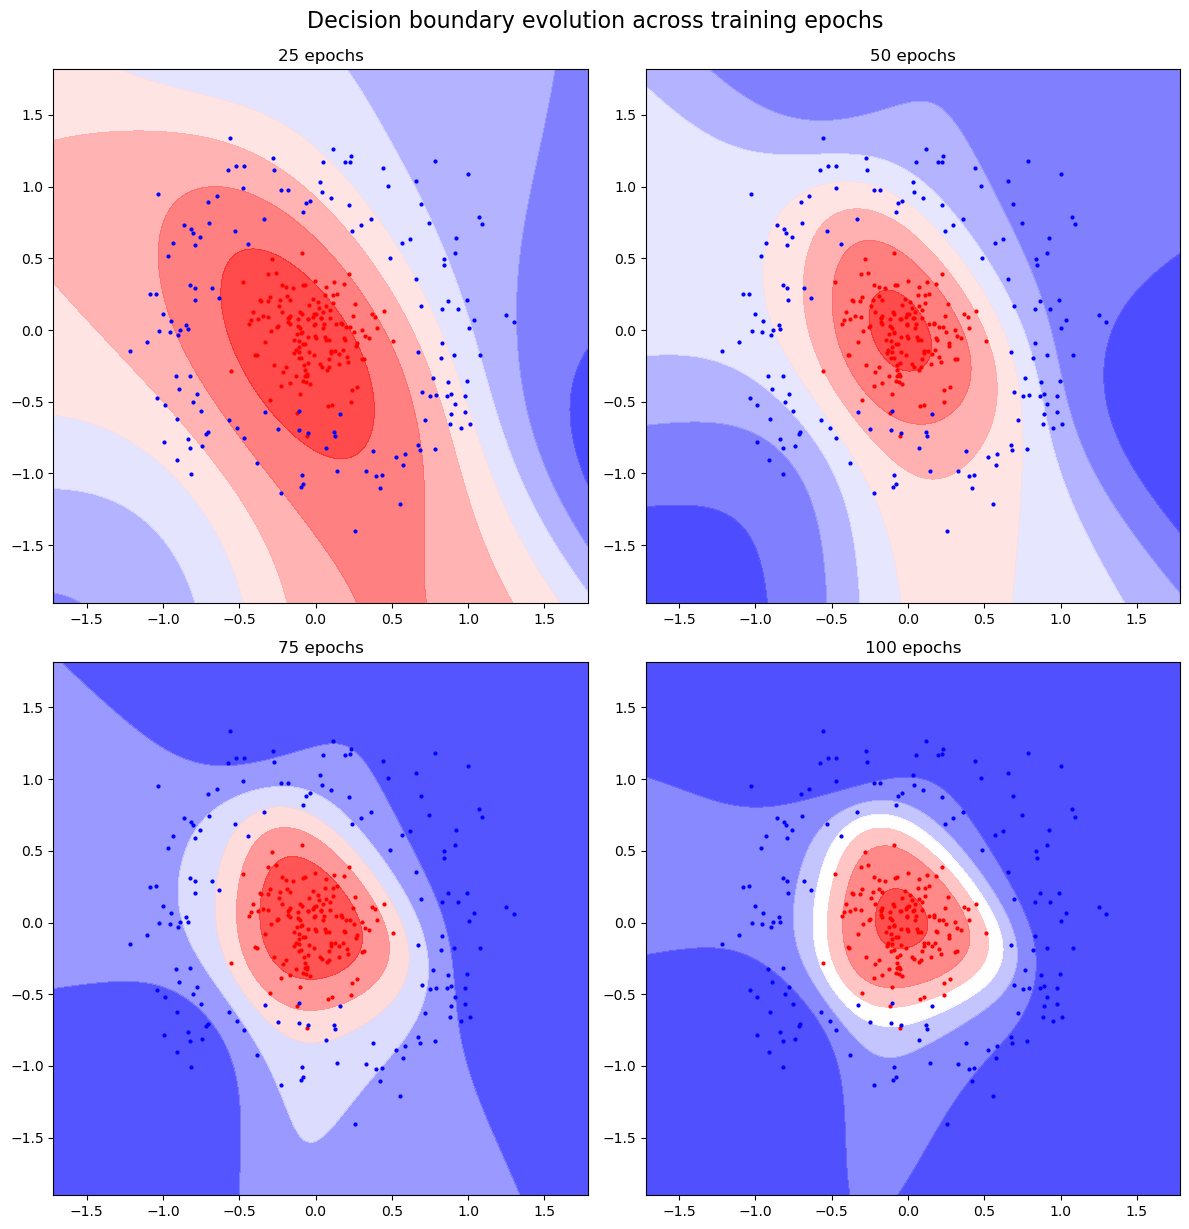

In [13]:
epochs_list = [25, 50, 75, 100]
eta = 0.01

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for idx, epochs in enumerate(epochs_list):
    np.random.seed(0)
    mlp_tmp = MLP(X, y, archi)   # fresh network
    mlp_tmp.train(epochs, eta)

    plot_decision_boundary(axes[idx], mlp_tmp, X, y)
    axes[idx].set_title(f"{epochs} epochs")

plt.tight_layout()
fig.suptitle("Decision boundary evolution across training epochs", fontsize=16, y=1.02)
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
    
At early stages of training (25 epochs), the decision boundary is coarse and does not yet properly separate the two classes, indicating underfitting. As training progresses (50 and 75 epochs), the boundary gradually adapts to the structure of the data, becoming smoother and better aligned with the underlying distribution. After 100 epochs, the network converges to a stable nonlinear decision boundary that correctly captures the circular structure of the dataset.

This experiment demonstrates the ability of a shallow neural network with sigmoid activations to learn nonlinear decision boundaries that are not linearly separable. It also highlights the importance of sufficient training iterations for convergence.
</div>